## Twitter + Watson Tone Analyzer Sample Notebook

In [4]:
# Import SQLContext and data types
from pyspark.sql import SQLContext
from pyspark.sql.types import *

## Load the data

In [5]:
parquetFile = sqlContext.read.parquet("swift://notebooks.spark/tweetsFull2.parquet")
print parquetFile

DataFrame[author: string, date: string, lang: string, text: string, lat: double, long: double, Cheerfulness: double, Negative: double, Anger: double, Analytical: double, Confident: double, Tentative: double, Openness: double, Agreeableness: double, Conscientiousness: double]


In [6]:
parquetFile.registerTempTable("tweets");
sqlContext.cacheTable("tweets")
tweets = sqlContext.sql("SELECT * FROM tweets")
print tweets.count()
tweets.cache()

2846


DataFrame[author: string, date: string, lang: string, text: string, lat: double, long: double, Cheerfulness: double, Negative: double, Anger: double, Analytical: double, Confident: double, Tentative: double, Openness: double, Agreeableness: double, Conscientiousness: double]

## Compute the distribution of tweets by sentiments > 60%

In [7]:
#create an array that will hold the count for each sentiment
sentimentDistribution=[0] * 13
#For each sentiment, run a sql query that counts the number of tweets for which the sentiment score is greater than 60%
#Store the data in the array
for i, sentiment in enumerate(tweets.columns[-13:]):
    sentimentDistribution[i]=sqlContext.sql("SELECT count(*) as sentCount FROM tweets where " + sentiment + " > 60")\
        .collect()[0].sentCount

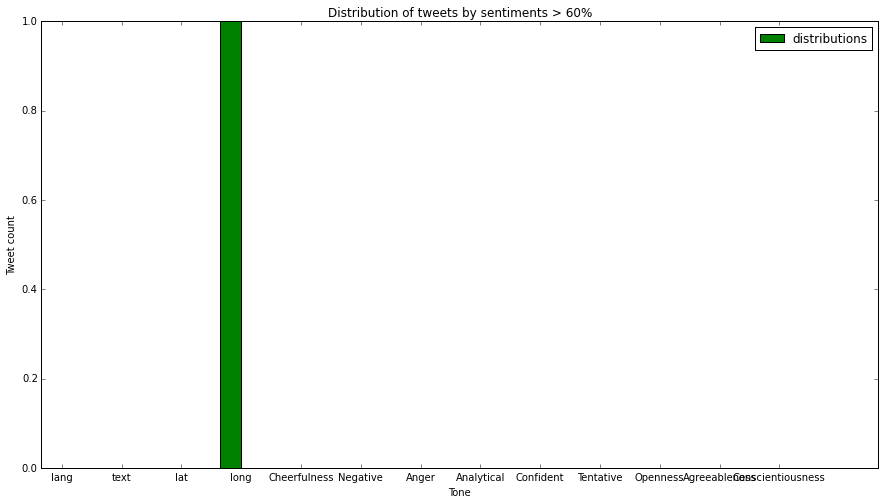

In [5]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

ind=np.arange(13)
width = 0.35
bar = plt.bar(ind, sentimentDistribution, width, color='g', label = "distributions")

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2.5, plSize[1]*2) )
plt.ylabel('Tweet count')
plt.xlabel('Tone')
plt.title('Distribution of tweets by sentiments > 60%')
plt.xticks(ind+width, tweets.columns[-13:])
plt.legend()

plt.show()

In [8]:
from operator import add
import re
tagsRDD = tweets.flatMap( lambda t: re.split("\s", t.text))\
    .filter( lambda word: word.startswith("#") )\
    .map( lambda word : (word, 1 ))\
    .reduceByKey(add, 10).map(lambda (a,b): (b,a)).sortByKey(False).map(lambda (a,b):(b,a))
top10tags = tagsRDD.take(10)

[(u'#Caps', 4), (u'#RAW', 3), (u'#ALDUBActing101', 3), (u'#survivor', 2), (u'#walk', 2), (u'#cancer', 2), (u'#breast', 2), (u'#LHHATL', 2), (u'#MKXProLeague', 1), (u'#videotutorial', 1)]


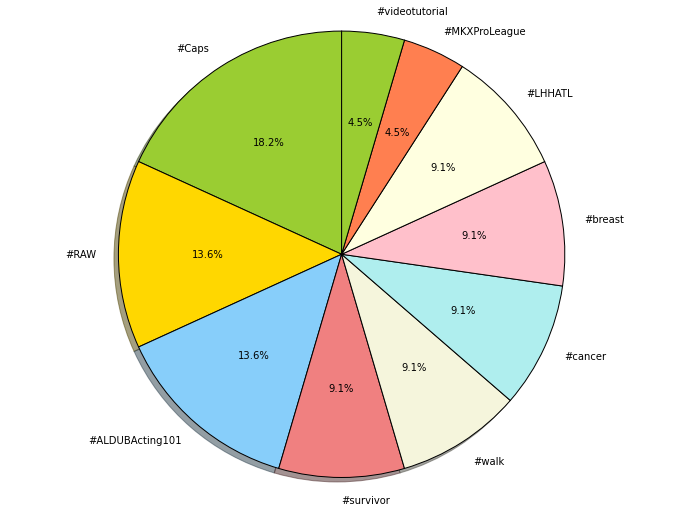

In [14]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

print(top10tags)
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*2) )

labels = [i[0] for i in top10tags]
sizes = [int(i[1]) for i in top10tags]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', "beige", "paleturquoise", "pink", "lightyellow", "coral"]

plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')

plt.show()

## Breakdown of the top 5 hashtags by sentiment scores
In this section, we demonstrate how to build a more complex analytic which decompose the top 5 hashtags by sentiment scores. The code below computes the mean of all the sentiment scores and visualize them in a multi-series bar chart

In [9]:
cols = tweets.columns[-13:]
def expand( t ):
    ret = []
    for s in [i[0] for i in top10tags]:
        if ( s in t.text ):
            for tone in cols:
                ret += [s.replace(':','').replace('-','') + u"-" + unicode(tone) + ":" + unicode(getattr(t, tone))]
    return ret 
def makeList(l):
    return l if isinstance(l, list) else [l]

#Create RDD from tweets dataframe
tagsRDD = tweets.map(lambda t: t )

#Filter to only keep the entries that are in top10tags
tagsRDD = tagsRDD.filter( lambda t: any(s in t.text for s in [i[0] for i in top10tags] ) )

#Create a flatMap using the expand function defined above, this will be used to collect all the scores 
#for a particular tag with the following format: Tag-Tone-ToneScore
tagsRDD = tagsRDD.flatMap( expand )

#Create a map indexed by Tag-Tone keys 
tagsRDD = tagsRDD.map( lambda fullTag : (fullTag.split(":")[0], float( fullTag.split(":")[1]) ))

#Call combineByKey to format the data as follow
#Key=Tag-Tone
#Value=(count, sum_of_all_score_for_this_tone)
tagsRDD = tagsRDD.combineByKey((lambda x: (x,1)),
                  (lambda x, y: (x[0] + y, x[1] + 1)),
                  (lambda x, y: (x[0] + y[0], x[1] + y[1])))

#ReIndex the map to have the key be the Tag and value be (Tone, Average_score) tuple
#Key=Tag
#Value=(Tone, average_score)
tagsRDD = tagsRDD.map(lambda (key, ab): (key.split("-")[0], (key.split("-")[1], round(ab[0]/ab[1], 2))))

#Reduce the map on the Tag key, value becomes a list of (Tone,average_score) tuples
tagsRDD = tagsRDD.reduceByKey( lambda x, y : makeList(x) + makeList(y) )

#Sort the (Tone,average_score) tuples alphabetically by Tone
tagsRDD = tagsRDD.mapValues( lambda x : sorted(x) )

#Format the data as expected by the plotting code in the next cell. 
#map the Values to a tuple as follow: ([list of tone], [list of average score])
#e.g. #someTag:([u'Agreeableness', u'Analytical', u'Anger', u'Cheerfulness', u'Confident', u'Conscientiousness', u'Negative', u'Openness', u'Tentative'], [1.0, 0.0, 0.0, 1.0, 0.0, 0.48, 0.0, 0.02, 0.0])
tagsRDD = tagsRDD.mapValues( lambda x : ([elt[0] for elt in x],[elt[1] for elt in x])  )

#Use custom sort function to sort the entries by order of appearance in top10tags
def customCompare( key ):
    for (k,v) in top10tags:
        if k == key:
            return v
    return 0
tagsRDD = tagsRDD.sortByKey(ascending=False, numPartitions=None, keyfunc = customCompare)

#Take the mean tone scores for the top 10 tags

top10tagsMeanScores = tagsRDD.take(10)


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 39.0 failed 10 times, most recent failure: Lost task 0.9 in stage 39.0 (TID 75, yp-spark-dal09-env5-0028): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/src/spark160master/spark-1.6.0-bin-2.6.0/python/lib/pyspark.zip/pyspark/worker.py", line 111, in main
    process()
  File "/usr/local/src/spark160master/spark-1.6.0-bin-2.6.0/python/lib/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/src/bluemix_ipythonspark_16/spark/python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/src/bluemix_ipythonspark_16/spark/python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/src/bluemix_ipythonspark_16/spark/python/pyspark/rdd.py", line 317, in func
    return f(iterator)
  File "/usr/local/src/bluemix_ipythonspark_16/spark/python/pyspark/rdd.py", line 1776, in combineLocally
    merger.mergeValues(iterator)
  File "/usr/local/src/spark160master/spark-1.6.0-bin-2.6.0/python/lib/pyspark.zip/pyspark/shuffle.py", line 236, in mergeValues
    for k, v in iterator:
  File "<ipython-input-9-46ff8044face>", line 23, in <lambda>
ValueError: could not convert string to float: en

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:342)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:73)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:41)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:213)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1153)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.lang.Thread.run(Thread.java:785)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1431)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1419)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1418)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1418)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1640)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1588)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at java.lang.Thread.getStackTrace(Thread.java:1117)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:620)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1837)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1850)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1863)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:393)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:95)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:55)
	at java.lang.reflect.Method.invoke(Method.java:507)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Thread.java:785)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/src/spark160master/spark-1.6.0-bin-2.6.0/python/lib/pyspark.zip/pyspark/worker.py", line 111, in main
    process()
  File "/usr/local/src/spark160master/spark-1.6.0-bin-2.6.0/python/lib/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/src/bluemix_ipythonspark_16/spark/python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/src/bluemix_ipythonspark_16/spark/python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/src/bluemix_ipythonspark_16/spark/python/pyspark/rdd.py", line 317, in func
    return f(iterator)
  File "/usr/local/src/bluemix_ipythonspark_16/spark/python/pyspark/rdd.py", line 1776, in combineLocally
    merger.mergeValues(iterator)
  File "/usr/local/src/spark160master/spark-1.6.0-bin-2.6.0/python/lib/pyspark.zip/pyspark/shuffle.py", line 236, in mergeValues
    for k, v in iterator:
  File "<ipython-input-9-46ff8044face>", line 23, in <lambda>
ValueError: could not convert string to float: en

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:342)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:73)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:41)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:213)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1153)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


In [10]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*3, plSize[1]*2) )

top5tagsMeanScores = top10tagsMeanScores[:5]
width = 0
ind=np.arange(13)
(a,b) = top5tagsMeanScores[0]
labels=b[0]
colors = ["beige", "paleturquoise", "pink", "lightyellow", "coral", "lightgreen", "gainsboro", "aquamarine","c"]
idx=0
for key, value in top5tagsMeanScores:
    plt.bar(ind + width, value[1], 0.15, color=colors[idx], label=key)
    width += 0.15
    idx += 1
plt.xticks(ind+0.3, labels)
plt.ylabel('AVERAGE SCORE')
plt.xlabel('TONES')
plt.title('Breakdown of top hashtags by sentiment tones')

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='center',ncol=5, mode="expand", borderaxespad=0.)

plt.show()

NameError: name 'top10tagsMeanScores' is not defined